In [28]:
import pandas as pd
import os
import re

# File paths to the datasets
file_paths = [
    "Tue27AugWoolworths.csv",
    "Tue10SepWoolworths.csv",
    "Wed04SepWoolworths.csv",
    "Sun4AugWoolworths.csv",
    "Tue03SepWoolworths.csv"
]

# Function to extract the date from file name and add it to the dataframe
def load_and_add_date(file_path):
    # Load the dataset
    data = pd.read_csv(file_path)
    
    # Extract the date using a regex pattern (e.g., 27Aug, 10Sep, etc.)
    file_name = os.path.basename(file_path)
    date_match = re.search(r'\d{1,2}[A-Za-z]{3}', file_name)
    
    if date_match:
        date_str = date_match.group() + ' 2019'  # Extract correct date format and append year
        # Convert to datetime format
        data['Date'] = pd.to_datetime(date_str, format='%d%b %Y')
    
    return data

# Load and combine all datasets
all_data = pd.concat([load_and_add_date(fp) for fp in file_paths], ignore_index=True)

# Display the combined data
print(all_data.head())


   Product Code     Category                    Item Name Best Price  \
0        133211  Fruit & Veg       Cavendish Bananas Each     $0.81    
1        134034  Fruit & Veg            Fresh Tomato Each     $0.54    
2        144607  Fruit & Veg     Strawberries 250g Punnet     $2.80    
3        105919  Fruit & Veg  Fresh Pink Lady Apples Each     $0.86    
4        169438  Fruit & Veg          Truss Tomatoes Each     $1.11    

  Best Unit Price Item Price    Unit Price Price Was Special Text  \
0     $0.81 / 1EA     $0.81    $0.81 / 1EA       NaN          NaN   
1     $0.54 / 1EA     $0.54    $0.54 / 1EA       NaN          NaN   
2    $11.20 / 1KG     $2.80   $11.20 / 1KG       NaN          NaN   
3     $0.86 / 1EA     $0.86    $0.86 / 1EA       NaN          NaN   
4     $1.11 / 1EA     $1.11    $1.11 / 1EA       NaN          NaN   

  Complex Promo Text                                               Link  \
0                NaN  https://www.woolworths.com.au/shop/productdeta...   
1 

In [29]:
# Cleaning the 'Best Price' column
all_data['Best Price Cleaned'] = pd.to_numeric(all_data['Best Price'].replace('[\$,]', '', regex=True))

# Display the cleaned data
print(all_data[['Item Name', 'Best Price', 'Best Price Cleaned', 'Date']].head())


                     Item Name Best Price  Best Price Cleaned       Date
0       Cavendish Bananas Each     $0.81                 0.81 2019-08-27
1            Fresh Tomato Each     $0.54                 0.54 2019-08-27
2     Strawberries 250g Punnet     $2.80                 2.80 2019-08-27
3  Fresh Pink Lady Apples Each     $0.86                 0.86 2019-08-27
4          Truss Tomatoes Each     $1.11                 1.11 2019-08-27


In [30]:
# Group the data by 'Item Name' and 'Date' to get the average price for each item over time
grouped_data = all_data.groupby(['Item Name', 'Date'])['Best Price Cleaned'].mean().reset_index()

# Display the grouped data
print(grouped_data.head())


                           Item Name       Date  Best Price Cleaned
0  & Ginger Beer Cans 355ml X 4 Pack 2019-08-04                21.0
1  & Pink Gin With Wildberries 500ml 2019-08-04                41.0
2  & Pink Gin With Wildberries 500ml 2019-08-27                42.0
3  & Pink Gin With Wildberries 500ml 2019-09-03                41.0
4  & Pink Gin With Wildberries 500ml 2019-09-04                41.0


In [31]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Extract relevant columns for the LSTM model
lstm_data = grouped_data[['Best Price Cleaned', 'Date']].copy()

# Sort by date for sequential data
lstm_data = lstm_data.sort_values(by='Date')

# Scale the data using MinMaxScaler to normalize it
scaler = MinMaxScaler(feature_range=(0, 1))
lstm_data['Best Price Cleaned'] = scaler.fit_transform(lstm_data[['Best Price Cleaned']])

# Prepare input data: create sequences for LSTM input (you can adjust the window size)
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Set sequence length (window size)
seq_length = 10  # This is adjustable

# Prepare the sequences
X, y = create_sequences(lstm_data['Best Price Cleaned'].values, seq_length)

# Reshape the data to fit LSTM input (samples, time steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))


In [32]:
# Split the data into training and testing sets (80% train, 20% test)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [38]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Define a more complex LSTM model
model = Sequential()

# First LSTM layer with more units and returning sequences for stacking LSTMs
model.add(LSTM(units=100, return_sequences=True, input_shape=(seq_length, 1)))
model.add(Dropout(0.2))

# Second LSTM layer with 50 units
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=30, batch_size=64)


C:\Users\anjup\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 45s 30ms/step - loss: 0.0024
Epoch 2/30
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 39s 29ms/step - loss: 0.0024
Epoch 3/30
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 38s 29ms/step - loss: 0.0023
Epoch 4/30
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 37s 29ms/step - loss: 0.0024
Epoch 5/30
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 37s 28ms/step - loss: 0.0024
Epoch 6/30
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 37s 28ms/step - loss: 0.0025
Epoch 7/30
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 38s 29ms/step - loss: 0.0023
Epoch 8/30
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 38s 29ms/step - loss: 0.0023
Epoch 9/30
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - loss: 0.0023
Epoch 10/30
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 38s 29ms/step - loss: 0.0022
Epoch 11/30
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 38s 29ms/step - loss: 0.0023
Epoch 12/30
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 38s 29ms/step - loss: 0.0023
Epoch 13/30
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 38s 29ms/step - loss: 0.0022
Epoch 14/30
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 38s 29ms/step - loss: 0.0023
E

655/655 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0023
Test Loss: 0.0021006676834076643
655/655 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step


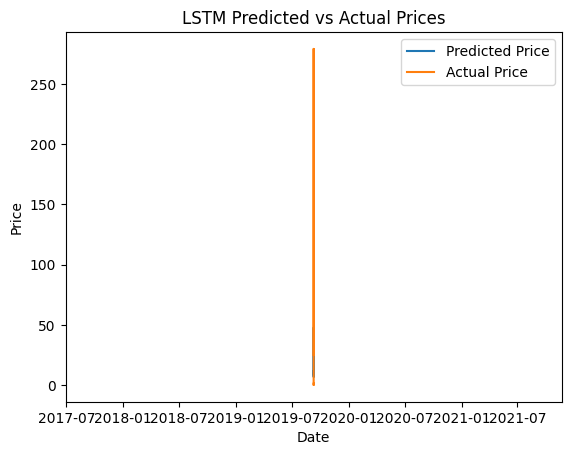

In [39]:
# Evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

# Make predictions on the test set
predicted_prices = model.predict(X_test)

# Rescale the predicted prices back to the original scale
predicted_prices = scaler.inverse_transform(predicted_prices)

# Compare the predicted and actual prices
import matplotlib.pyplot as plt

plt.plot(lstm_data['Date'][split+seq_length:], predicted_prices, label='Predicted Price')
plt.plot(lstm_data['Date'][split+seq_length:], scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual Price')
plt.title('LSTM Predicted vs Actual Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [40]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Rescale the predicted prices and test labels back to the original scale
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_rescaled, predicted_prices))
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Calculate MAE
mae = mean_absolute_error(y_test_rescaled, predicted_prices)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate MSE
mse = mean_squared_error(y_test_rescaled, predicted_prices)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate R-Squared
r2 = r2_score(y_test_rescaled, predicted_prices)
print(f'R-Squared (R²): {r2}')


655/655 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step
Root Mean Squared Error (RMSE): 14.8434879331613
Mean Absolute Error (MAE): 8.097002175024487
Mean Squared Error (MSE): 220.32913402190516
R-Squared (R²): 0.05906896665456529
